In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import dgl
from sklearn.preprocessing import LabelEncoder, StandardScaler
import h5py
import networkx as nx 
from torch_geometric.utils.convert import from_dgl
import dask.dataframe as dd


/home/taznk/COMP4003/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import dgl
import numpy as np

def get_batch(data):
    all_data = data.copy()
    while len(all_data) > 0:
        if len(all_data) >= 5000:
            batch = all_data.sample(5000)
            all_data = all_data.drop(batch.index)
            yield batch
        else:
            batch = all_data.copy()
            all_data = all_data.drop(batch.index)
            yield batch
            
def to_graph(data):
    G = nx.from_pandas_edgelist(data, source='src', 
                                target='dst', 
                                edge_attr=['x', 'Attack'], 
                                create_using=nx.MultiGraph())
    
    G = G.to_directed()
    # NOTE paper also uses 'i' index for each node as an identifier
    g = dgl.from_networkx(G, edge_attrs=[ 'x', 'Attack'])
    g = g.line_graph(shared=True)
    return from_dgl(g) 

In [3]:
data = pd.read_csv('interm/BoT-processed_flows.csv')
data = data.drop('Unnamed: 0', axis=1)
attrs = [c for c in data.columns if c not in ("src", "dst", "Attack", "x")]
data['x'] = data[attrs].values.tolist()
len(data['x'][0])

49

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, train_size=0.8, random_state=0)
len(train), len(test)

(59516, 14880)

In [6]:
train.to_csv('interm/BoT_train.csv', index=False)
test.to_csv('interm/BoT_test.csv', index=False)

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch_geometric.nn.models.basic_gnn import GraphSAGE

device = 'cpu'

model = GraphSAGE(
    49,
    hidden_channels=256,
    out_channels=5,
    num_layers=3,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train_epoch(model, train, test):
    model.train()
    total_loss = 0
    for batch in tqdm(get_batch(data)):
        G = to_graph(batch)
        
        optimizer.zero_grad()
        G = G.to(device)   
        out= model(G.x.to(device), G.edge_index.to(device))
        loss = F.cross_entropy(out, G.Attack)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    model.eval()
    total_test_loss = 0
    for batch in tqdm(get_batch(test)):
        G = to_graph(batch)
        
        with torch.no_grad():
            out = model(G.x.to(device), G.edge_index.to(device))
            total_test_loss += F.cross_entropy(out, G.Attack)
        
    return total_loss / np.ceil(len(train) / 5000), total_test_loss / np.ceil(len(test) / 5000)


loss, test_loss = train_epoch(model, train, test)
loss, test_loss

0it [00:00, ?it/s]

15it [00:20,  1.34s/it]
3it [00:03,  1.24s/it]


(np.float64(13.967396035790443), tensor(0.6524))

In [13]:
import pickle

with open('interm/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)
    
encoders

{'L7_PROTO': LabelEncoder(),
 'ICMP_TYPE': LabelEncoder(),
 'ICMP_IPV4_TYPE': LabelEncoder(),
 'DNS_QUERY_TYPE': LabelEncoder(),
 'FTP_COMMAND_RET_CODE': LabelEncoder(),
 'Attack': LabelEncoder()}

epoch: 1


0it [00:00, ?it/s]

15it [00:20,  1.34s/it]
3it [00:03,  1.13s/it]


0.13213601149618626 tensor(0.1074)
epoch: 2


15it [00:19,  1.32s/it]
3it [00:03,  1.13s/it]


0.13628894835710526 tensor(0.1079)
epoch: 3


15it [00:19,  1.32s/it]
3it [00:03,  1.15s/it]


0.13566807409127554 tensor(0.1069)
epoch: 4


15it [00:19,  1.31s/it]
3it [00:03,  1.15s/it]


0.1334626618772745 tensor(0.1098)
epoch: 5


15it [00:19,  1.30s/it]
3it [00:03,  1.23s/it]


0.13429512021442255 tensor(0.1081)
epoch: 6


15it [00:19,  1.31s/it]
3it [00:03,  1.14s/it]


0.13289478359123072 tensor(0.1088)
epoch: 7


15it [00:19,  1.31s/it]
3it [00:03,  1.14s/it]


0.13428361217180887 tensor(0.1101)
epoch: 8


15it [00:19,  1.30s/it]
3it [00:03,  1.13s/it]


0.1318851305792729 tensor(0.1058)
epoch: 9


15it [00:19,  1.31s/it]
3it [00:03,  1.14s/it]


0.13067025256653628 tensor(0.1074)
epoch: 10


15it [00:19,  1.33s/it]
3it [00:03,  1.14s/it]


0.1307088639587164 tensor(0.1070)
epoch: 11


15it [00:19,  1.33s/it]
3it [00:03,  1.16s/it]


0.1305523787935575 tensor(0.1053)
epoch: 12


15it [00:19,  1.32s/it]
3it [00:03,  1.14s/it]


0.1311666052788496 tensor(0.1069)
epoch: 13


15it [00:19,  1.33s/it]
3it [00:03,  1.16s/it]


0.1292426772415638 tensor(0.1046)
epoch: 14


15it [00:20,  1.34s/it]
3it [00:03,  1.18s/it]


0.12918705493211746 tensor(0.1043)
epoch: 15


15it [00:19,  1.31s/it]
3it [00:03,  1.15s/it]

0.12956293486058712 tensor(0.1038)


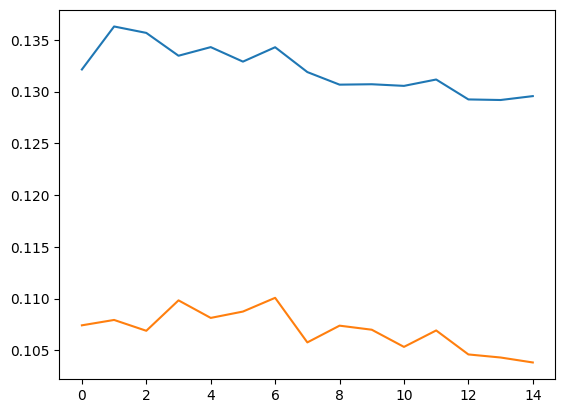

In [22]:
import matplotlib.pyplot as plt

l, tl = [], []
for epoch in range(15):
    print(f'epoch: {epoch+1}')
    loss, test_loss = train_epoch(model, train, test)
    l.append(loss)
    tl.append(test_loss)
    print(loss, test_loss)
    
plt.plot(l)
plt.plot(tl)
plt.show()

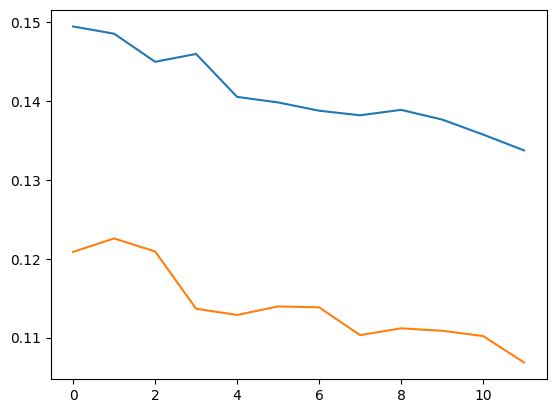

In [19]:
plt.plot(l)
plt.plot(tl)
plt.show()

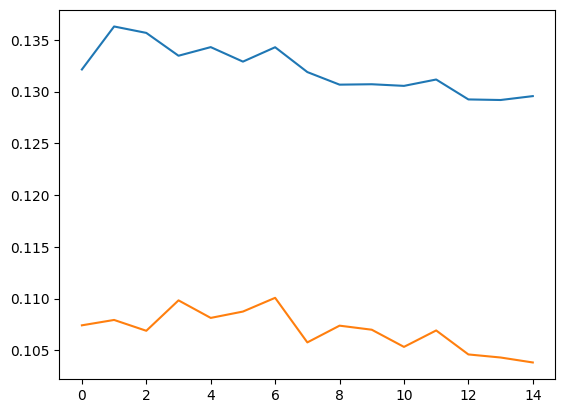

In [23]:
plt.plot(l)
plt.plot(tl)
plt.show()

In [24]:
le = encoders['Attack']
le.inverse_transform(list(range(4)))

array(['Benign', 'DDoS', 'DoS', 'Reconnaissance'], dtype=object)

In [25]:
from sklearn.metrics import classification_report



def evaluate(model, test, digits=4):
    model.eval()
    total_test_loss = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in tqdm(get_batch(test)):
            G = to_graph(batch)
        
            G = G.to(device)
            out = model(G.x, G.edge_index)
            preds = out.argmax(dim=1)
            
            y_true.append(G.Attack.cpu())
            y_pred.append(preds.cpu())
            
            total_test_loss += F.cross_entropy(out, G.Attack).item()
            del batch

    # Flatten all batches
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    return classification_report(y_true, y_pred, digits=digits)


cr = evaluate(model, test)
print({
    d: le.inverse_transform([d])
    for d in range(4)
})
print("\n🧾 Classification Report:")
print(cr)

0it [00:00, ?it/s]

3it [00:03,  1.14s/it]

{0: array(['Benign'], dtype=object), 1: array(['DDoS'], dtype=object), 2: array(['DoS'], dtype=object), 3: array(['Reconnaissance'], dtype=object)}

🧾 Classification Report:
              precision    recall  f1-score   support

           0     0.9919    0.9996    0.9957     22668
           1     0.7217    0.7904    0.7545      2156
           2     0.7626    0.6874    0.7231      2108
           3     0.9953    0.9117    0.9517      2096
           4     0.9946    0.9973    0.9959       732

    accuracy                         0.9561     29760
   macro avg     0.8932    0.8773    0.8842     29760
weighted avg     0.9564    0.9561    0.9558     29760



In [26]:
import torch as th

th.save(model.state_dict(), 'interm/GraphSAGE_BoTIoT.pth')